# Integrated Pipeline Test 🧪

This notebook tests the entire **Triage System**:
1.  **Input Image**
2.  **Stage 0 (YOLOv11):** Checks if the image is valid (Skin/Wound) or Irrelevant (Trash).
3.  **Stage 1 (EfficientNet):** If valid, checks if it's `Healthy Skin` or a `Wound`.

In [1]:
import sys
import matplotlib.pyplot as plt
from pathlib import Path
import glob
import math

# Add src to path
sys.path.append("../src")

from inference_pipeline import InferencePipeline

# Initialize Pipeline (First time loading might take a few seconds)
print("⏳ Loading Pipeline Models...")
pipeline = InferencePipeline()
print("✅ Pipeline Ready!")

f:\Housepital-AI\Housepital-AI\venv_gpu\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


⏳ Loading Pipeline Models...
✅ Stage 0 (YOLOv11) Loaded on cuda


f:\Housepital-AI\Housepital-AI\venv_gpu\Lib\site-packages\timm\models\_factory.py:138: UserWarning: Mapping deprecated model name tf_efficientnet_b0_ns to current tf_efficientnet_b0.ns_jft_in1k.
  model = create_fn(


✅ Stage 1 (EfficientNet) Loaded on cuda
✅ Pipeline Ready!


In [2]:
def test_and_plot_batch(folder_path, num_images=20, columns=5):
    """
    Tests a batch of images from a folder and plots them in a grid.
    """
    image_files = glob.glob(str(Path(folder_path) / "*.jpg")) + glob.glob(str(Path(folder_path) / "*.png"))
    
    # Limit images
    image_files = image_files[:num_images]
    
    if not image_files:
        print(f"⚠️ No images found in {folder_path}")
        return

    num_files = len(image_files)
    rows = math.ceil(num_files / columns)
    
    print(f"🔍 Testing {num_files} images from: {folder_path}")

    fig, axes = plt.subplots(rows, columns, figsize=(columns * 3, rows * 3.5))
    axes = axes.flatten() if num_files > 1 else [axes]
    
    for i, img_path in enumerate(image_files):
        # Run Prediction
        try:
            result = pipeline.predict(img_path)
            
            # Extract Info
            stage0 = result.get('stage0', {})
            stage1 = result.get('stage1', {})
            final = result['final_verdict']
            
            # Determine Title Color
            # Green if Correctly filtered as Irrelevant OR Correctly identified as Wound/Healthy (logic depends on expectation)
            # For visualization, we strictly color based on detection:
            # Red = Wound, Green = Healthy, Gray = Irrelevant
            
            title = final
            color = 'black'
            if "Irrelevant" in final:
                color = 'gray'
                subtitle = f"{stage0.get('confidence', 0):.0%} {stage0.get('class')}"
            elif "Healthy" in final:
                color = 'green'
                subtitle = f"S1: {stage1.get('probability', 0):.0%}"
            else: # Wound
                color = 'red'
                subtitle = f"S1: {stage1.get('probability', 0):.0%}"
            
            # Plot
            ax = axes[i]
            img = plt.imread(img_path)
            ax.imshow(img)
            ax.axis('off')
            ax.set_title(f"{title}\n{subtitle}", color=color, fontsize=10, fontweight='bold')
            
        except Exception as e:
            print(f"Error processing {img_path}: {e}")
            
    # Hide unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')
        
    plt.tight_layout()
    plt.show()

## 🧪 Batch Testing Results

🔍 Testing 20 images from: ../data/raw/background_class_highres


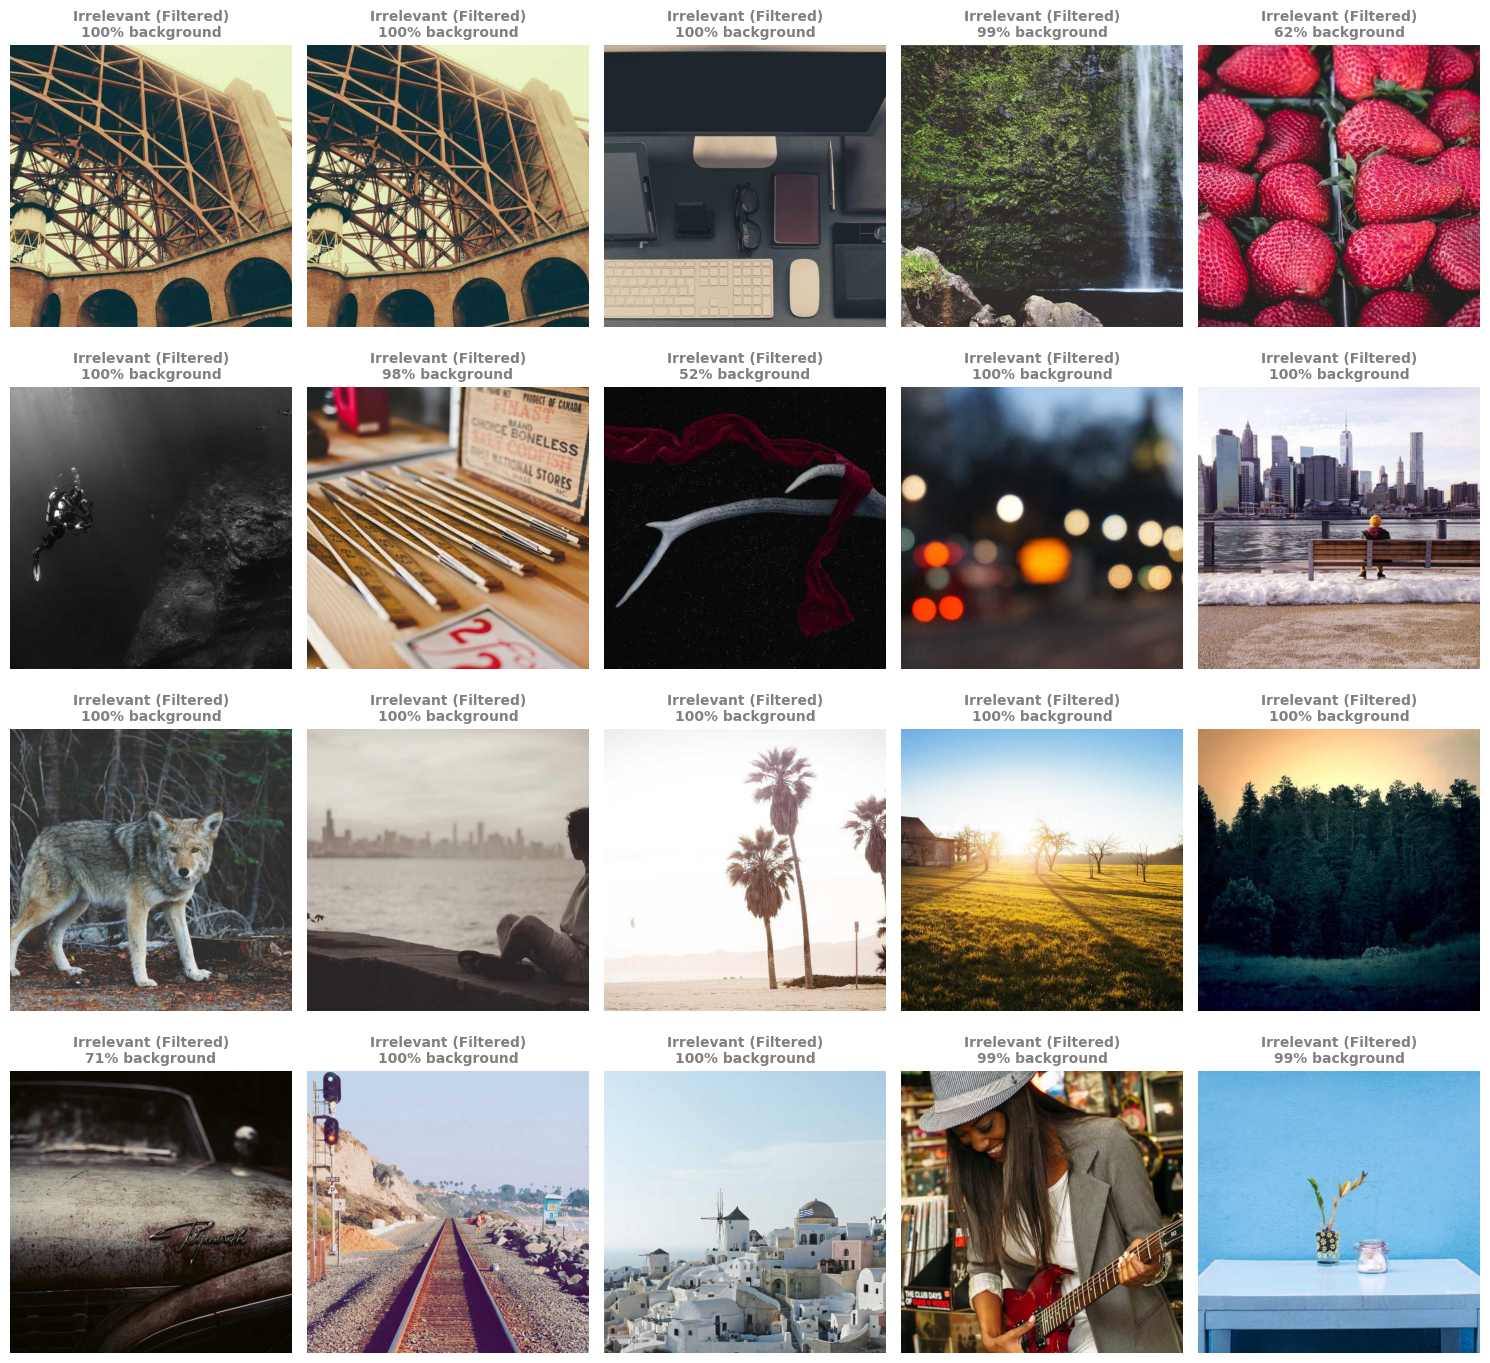

In [3]:
# 1. Test Background Images (Should be 'Irrelevant')
test_and_plot_batch("../data/raw/background_class_highres", num_images=20)

🔍 Testing 20 images from: ../data/raw/type_classification/healthy


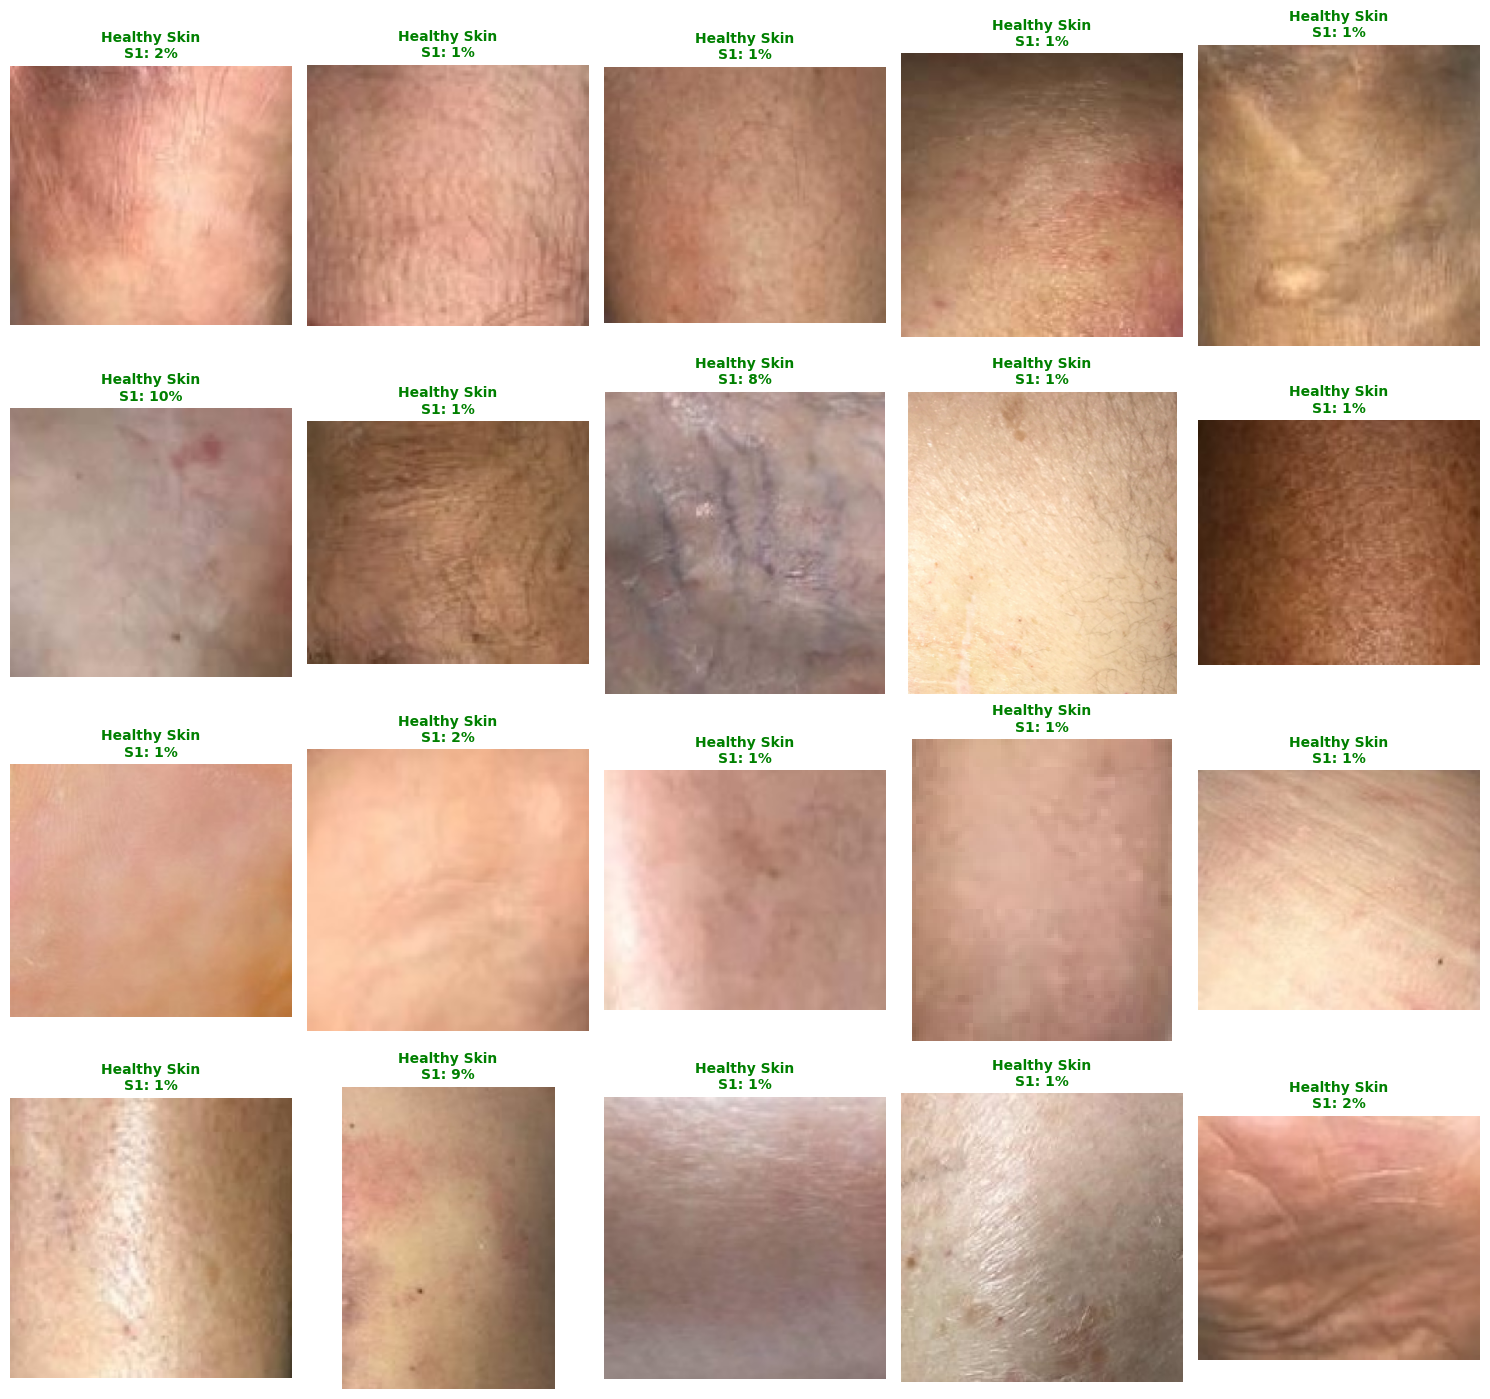

In [4]:
# 2. Test Healthy Skin (Should be 'Relevant' -> 'Healthy Skin')
test_and_plot_batch("../data/raw/type_classification/healthy", num_images=20)

🔍 Testing 20 images from: ../data/processed/yolo_stage0/train/background


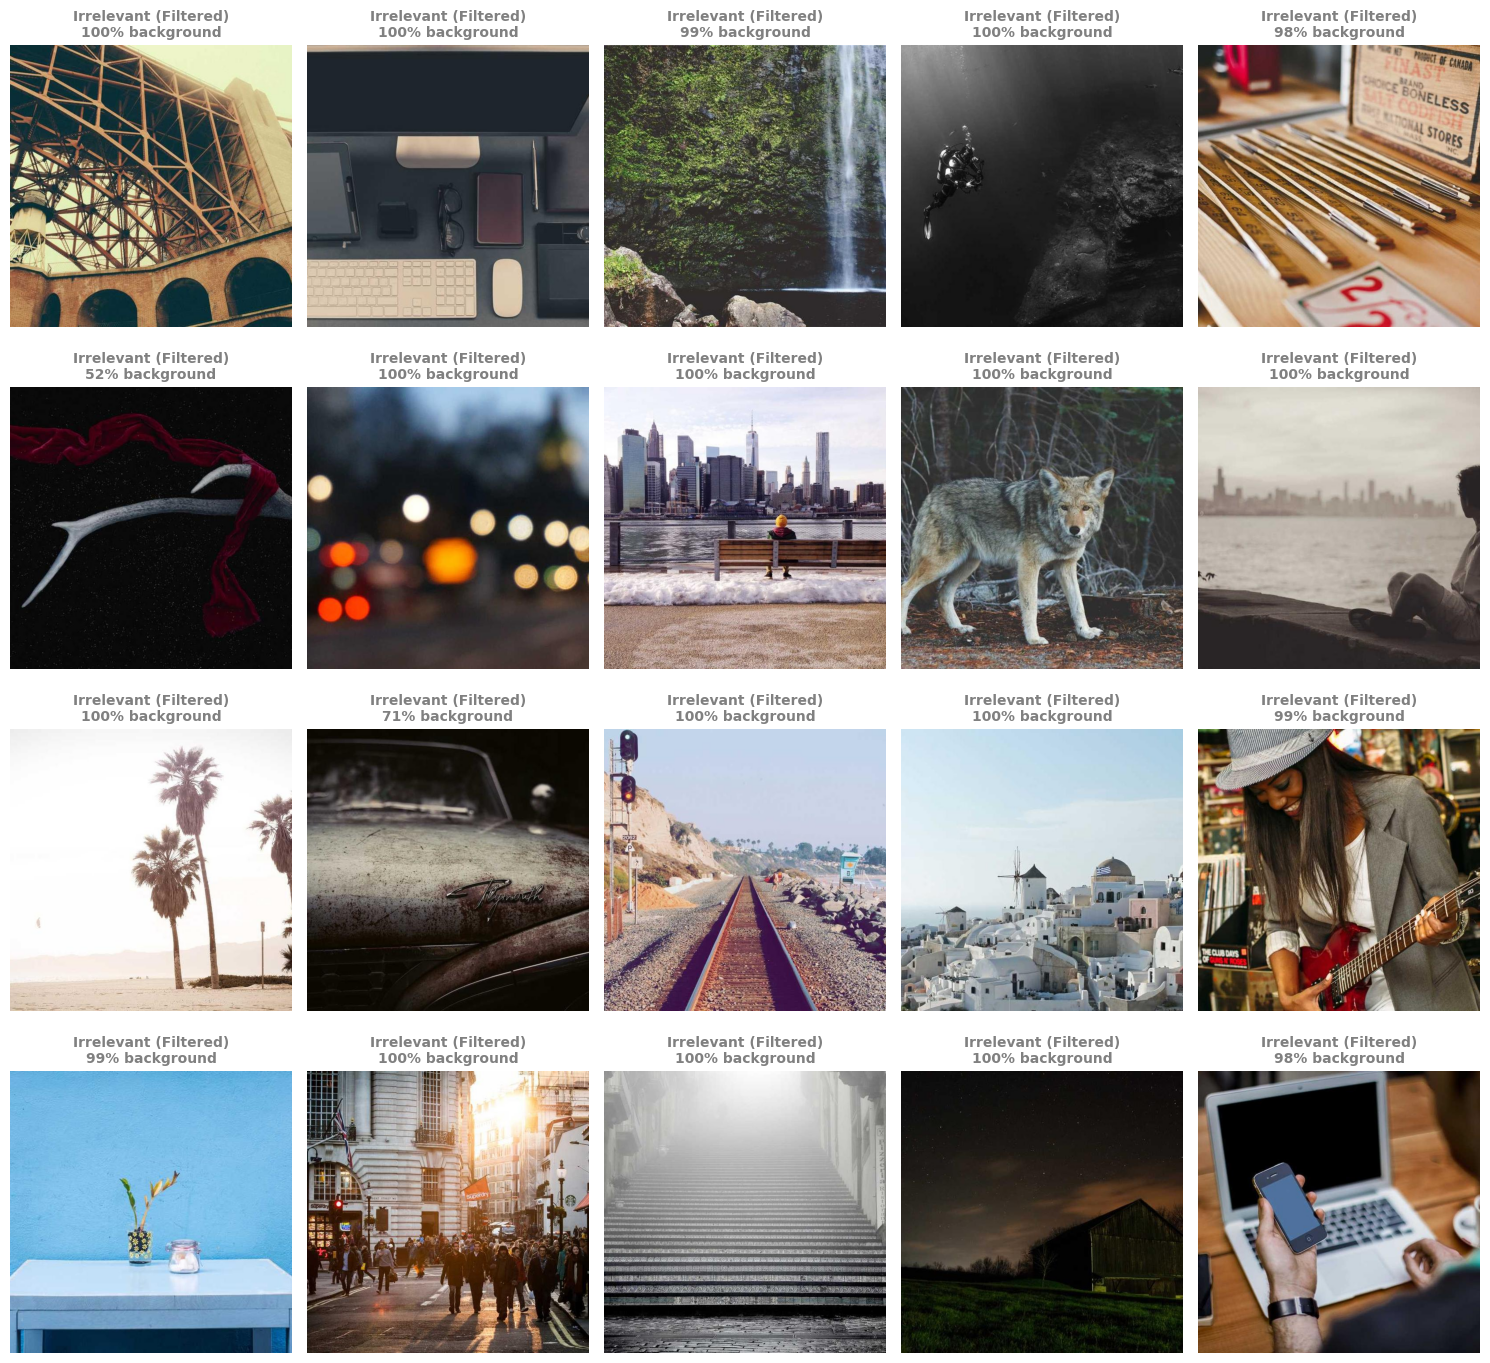

In [20]:
# 3. Test Wound Images (Should be 'Relevant' -> 'Wound Detected')
# test_and_plot_batch("../data/raw/type_classification/diabetic_foot", num_images=20)
test_and_plot_batch("../data/processed/yolo_stage0/train/background", num_images=20)